In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
warnings.filterwarnings("ignore")

In [93]:
data = pd.read_csv('../data/regional_xgboost_data.csv')
enc = pd.read_csv('../data/regional_datasets/xgboost/enc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
esc = pd.read_csv('../data/regional_datasets/xgboost/esc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
midatl = pd.read_csv('../data/regional_datasets/xgboost/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
mount = pd.read_csv('../data/regional_datasets/xgboost/mountain_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
ne = pd.read_csv('../data/regional_datasets/xgboost/new_england_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
pac = pd.read_csv('../data/regional_datasets/xgboost/pacific_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
satl = pd.read_csv('../data/regional_datasets/xgboost/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wnc = pd.read_csv('../data/regional_datasets/xgboost/wnc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')
wsc = pd.read_csv('../data/regional_datasets/xgboost/wsc_data_multi.csv').drop(columns = 'Unnamed: 0').set_index('date')

In [103]:
enc

,region,location_key,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,...,day,location_key_US_IL,location_key_US_IN,location_key_US_MI,location_key_US_OH,location_key_US_WI,1_day_shift,2_day_shift,7_day_shift,7_day_avg
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,East North Central,US_IL,0.0,0.0,4.0,0.0,0.0,35079.4,1295.1,612.7,...,4.0,1,0,0,0,0,NaN,NaN,NaN,NaN
2020-03-05,East North Central,US_IL,1.0,0.0,5.0,0.0,0.0,45302.3,1295.1,612.7,...,5.0,1,0,0,0,0,0.0,NaN,NaN,NaN
2020-03-06,East North Central,US_IL,0.0,0.0,5.0,0.0,0.0,45374.8,1295.1,612.7,...,6.0,1,0,0,0,0,1.0,0.0,NaN,NaN
2020-03-07,East North Central,US_IL,1.0,0.0,6.0,0.0,0.0,55608.1,1295.1,612.7,...,7.0,1,0,0,0,0,0.0,1.0,NaN,NaN
2020-03-08,East North Central,US_IL,0.0,0.0,6.0,0.0,0.0,51324.0,1211.4,446.7,...,8.0,1,0,0,0,0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,East North Central,US_WI,3995.0,4.0,1742220.0,14840.0,63.0,106716.0,428.0,56.0,...,11.0,0,0,0,0,1,0.0,0.0,0.0,1981.428571
2022-07-12,East North Central,US_WI,1894.0,2.0,1744114.0,14842.0,98.0,106814.0,471.0,60.0,...,12.0,0,0,0,0,1,3995.0,0.0,4345.0,1631.285714
2022-07-13,East North Central,US_WI,2236.0,7.0,1746350.0,14849.0,92.0,106906.0,481.0,58.0,...,13.0,0,0,0,0,1,1894.0,3995.0,1423.0,1747.428571


In [98]:
enc.sort_values('date')

,region,location_key,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,current_intensive_care_patients,...,day,location_key_US_IL,location_key_US_IN,location_key_US_MI,location_key_US_OH,location_key_US_WI,1_day_shift,2_day_shift,7_day_shift,7_day_avg
date,,,,,,,,,,,,,,,,,,,,,
2020-03-04,East North Central,US_IL,0.0,0.0,4.0,0.0,0.0,35079.4,1295.1,612.7,...,4.0,1,0,0,0,0,NaN,NaN,NaN,NaN
2020-03-05,East North Central,US_IL,1.0,0.0,5.0,0.0,0.0,45302.3,1295.1,612.7,...,5.0,1,0,0,0,0,0.0,NaN,NaN,NaN
2020-03-06,East North Central,US_IL,0.0,0.0,5.0,0.0,0.0,45374.8,1295.1,612.7,...,6.0,1,0,0,0,0,1.0,0.0,NaN,NaN
2020-03-07,East North Central,US_IL,1.0,0.0,6.0,0.0,0.0,55608.1,1295.1,612.7,...,7.0,1,0,0,0,0,0.0,1.0,NaN,NaN
2020-03-08,East North Central,US_IL,0.0,0.0,6.0,0.0,0.0,51324.0,1211.4,446.7,...,8.0,1,0,0,0,0,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-11,East North Central,US_WI,3995.0,4.0,1742220.0,14840.0,63.0,106716.0,428.0,56.0,...,11.0,0,0,0,0,1,0.0,0.0,0.0,1981.428571
2022-07-12,East North Central,US_WI,1894.0,2.0,1744114.0,14842.0,98.0,106814.0,471.0,60.0,...,12.0,0,0,0,0,1,3995.0,0.0,4345.0,1631.285714
2022-07-13,East North Central,US_WI,2236.0,7.0,1746350.0,14849.0,92.0,106906.0,481.0,58.0,...,13.0,0,0,0,0,1,1894.0,3995.0,1423.0,1747.428571


East North Central
MASE:  0.44540140372921305
{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 25}
-3698.7508527367036
East South Central
MASE:  0.31897334555050905
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 25}
-2041.1355148135785
Mid-Atlantic
MASE:  0.5012163713037452
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}
-4478.905675845293
Mountain
MASE:  0.5813351136480889
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 100}
-1627.1125595767728
New England
MASE:  0.30626314121388054
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 25}
-1793.0604135085318
Pacific
MASE:  0.5095776941247102
{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 25}
-7843.849241890636
South Atlantic
MASE:  0.4229118817201754
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}
-3908.1686126082227
West North Central
MASE:  0.3108865431829355
{'learning_rate': 0.25, 'max_depth': 5, 'n_estimators': 25}
-1467.1232924878072
West South Central
MASE:  0.225731813773064

<Figure size 1500x500 with 0 Axes>

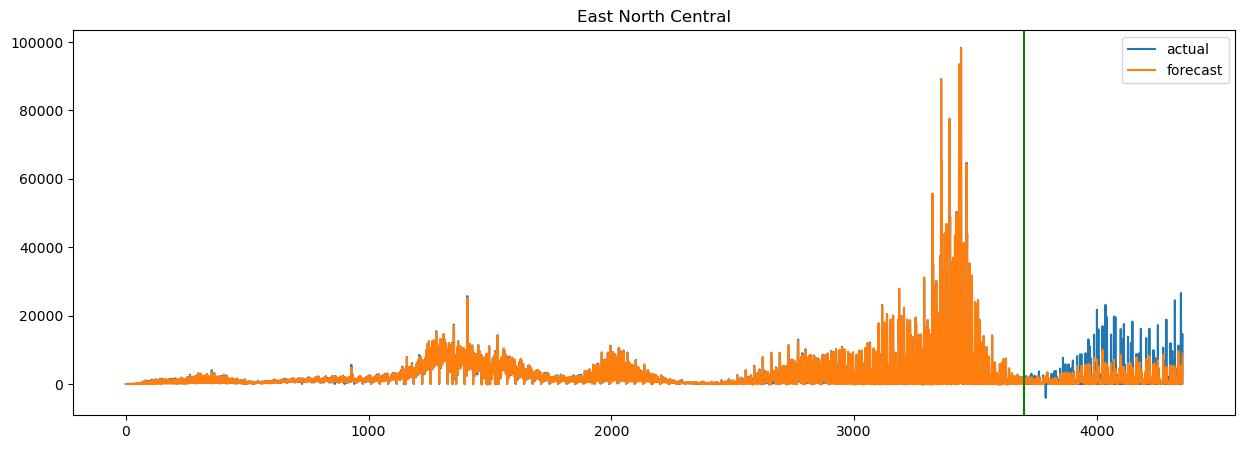

<Figure size 1500x500 with 0 Axes>

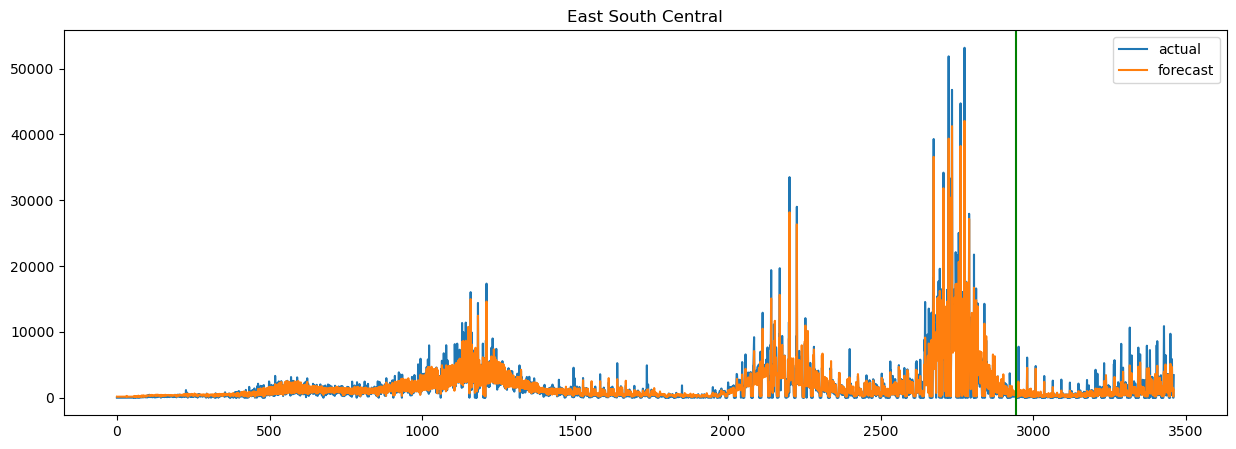

<Figure size 1500x500 with 0 Axes>

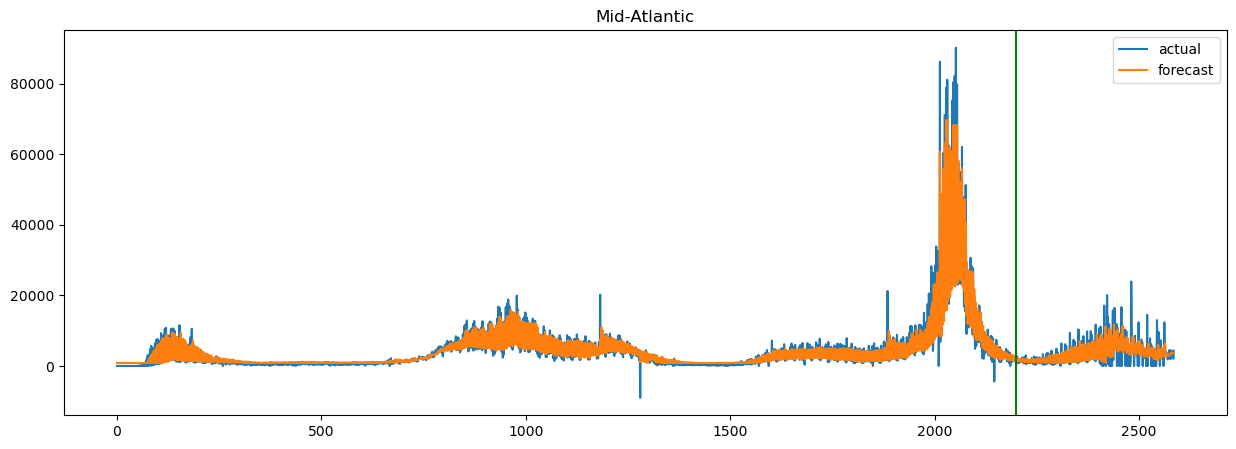

<Figure size 1500x500 with 0 Axes>

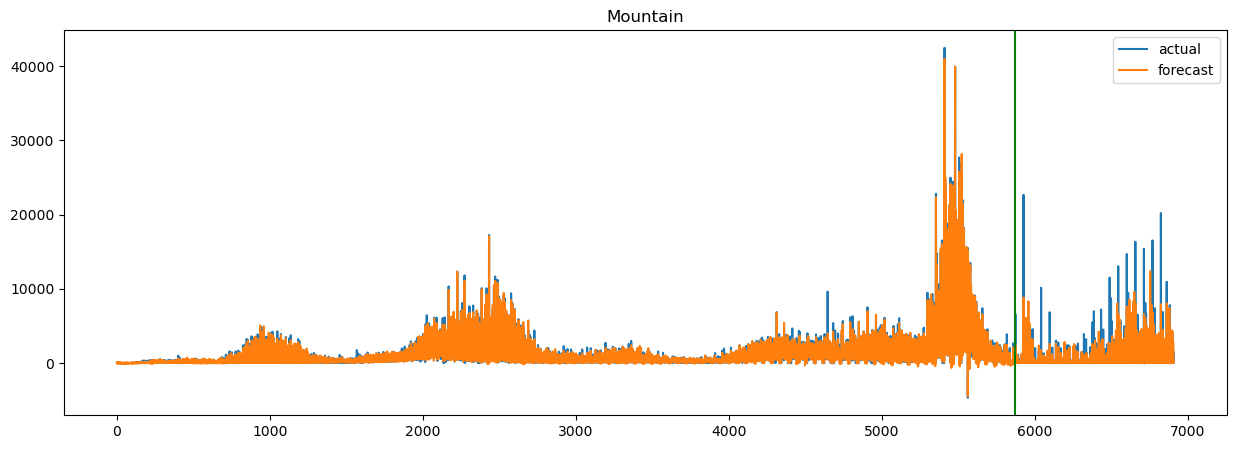

<Figure size 1500x500 with 0 Axes>

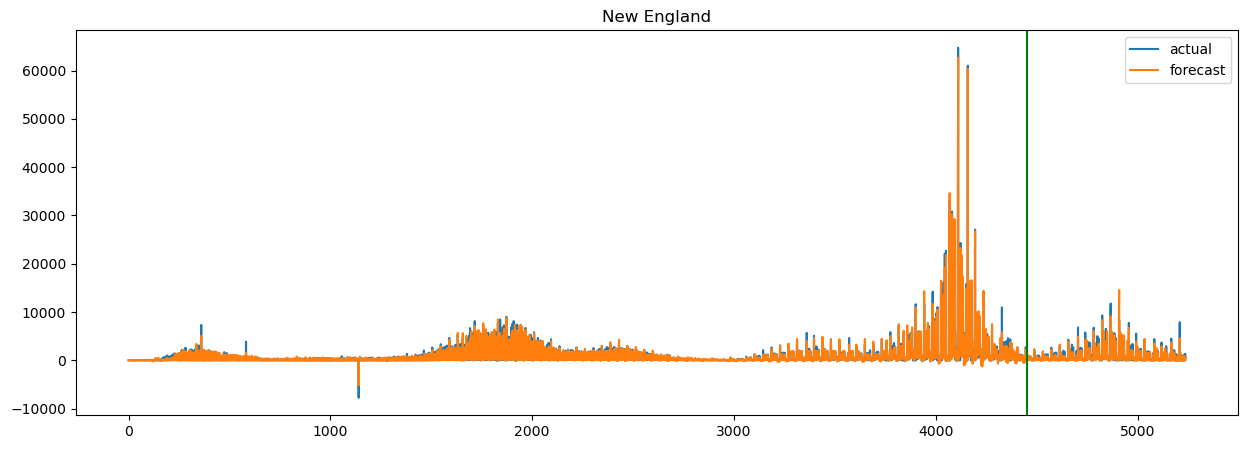

<Figure size 1500x500 with 0 Axes>

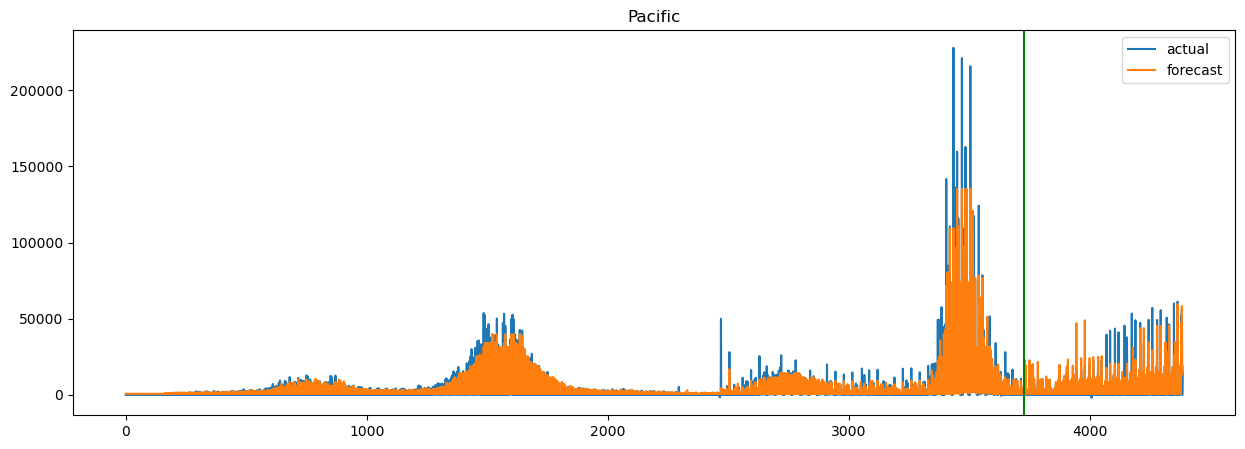

<Figure size 1500x500 with 0 Axes>

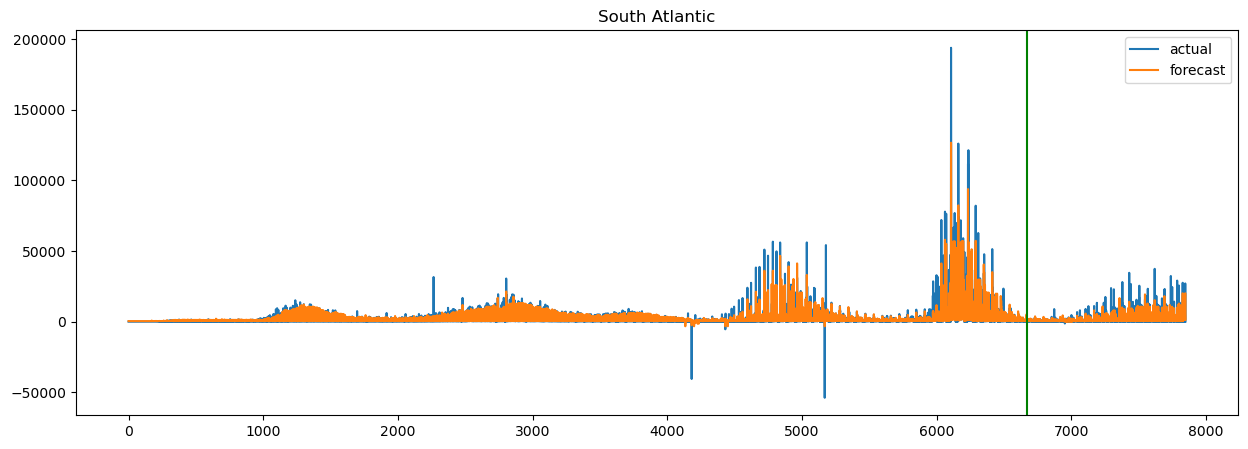

<Figure size 1500x500 with 0 Axes>

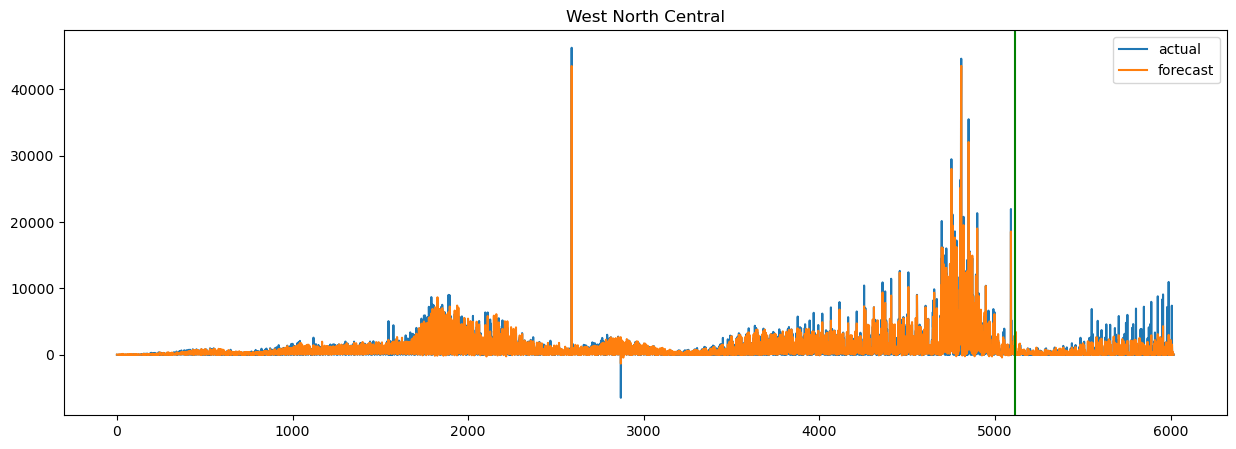

<Figure size 1500x500 with 0 Axes>

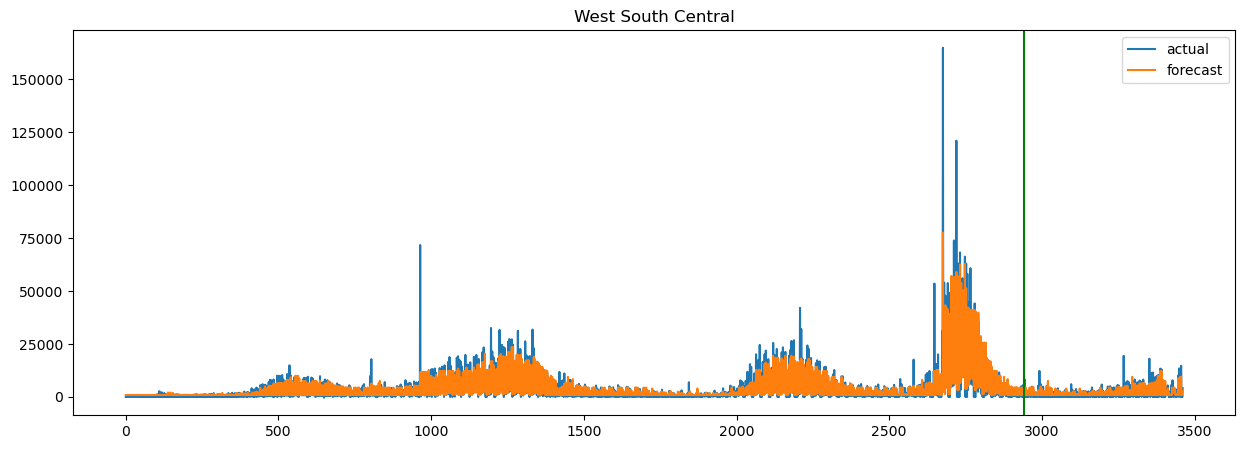

In [113]:
param_grid = {'n_estimators': [25, 50, 100, 300, 500],
              'learning_rate': [0.1, 0.15, 0.25, 0.3, 0.5],
              'max_depth': [2, 3, 5, 8]}
              # 'subsample': [0.5, 0.75, 1.0]}
from sklearn.metrics import make_scorer
mas_error = make_scorer(mean_absolute_scaled_error)
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.region.unique()[0])
    data = data.sort_values(by=['date', 'location_key'])
    df = data.drop(columns = ['region', 'location_key'])
    # df['new_confirmed'] = df['new_confirmed'].replace(0, np.nan)
    # df['log_target'] = np.log(df.new_confirmed)
    # df.dropna(inplace = True)
    # df.drop(columns = ['new_confirmed'], inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    size = round(data.shape[0]*0.15)
    Xtrain = X.iloc[:-size]
    Xtest = X.iloc[-size:]
    ytrain = y.iloc[:-size]
    ytest = y.iloc[-size:]
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)
    preds = stats[:10].index.tolist()
    X = df[preds]
    estimator = xgb.XGBRegressor()
    gscv = GridSearchCV(estimator = estimator,
                        param_grid = param_grid,
                        cv = 5,
                        scoring = 'neg_root_mean_squared_error', verbose = 0, n_jobs = -1)
    grid_result = gscv.fit(Xtrain, ytrain)
    model = xgb.XGBRegressor(n_estimators = grid_result.best_params_['n_estimators'],
                             learning_rate = grid_result.best_params_['learning_rate'],
                             max_depth = grid_result.best_params_['max_depth']).fit(Xtrain, ytrain)
    train_pred = model.predict(Xtrain)
    test_pred = model.predict(Xtest)
    test_pred = np.array([max(0, x) for x in test_pred])
    plt.figure(figsize = (15,5))
    pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
           pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))
    plt.legend(['actual', 'forecast'])
    plt.axvline(x = len(ytrain), color = 'green')
    plt.title(data.region.unique()[0])
    print('MASE: ', mean_absolute_scaled_error(ytest, test_pred, y_train = ytrain))
    print(grid_result.best_params_)
    print(grid_result.best_score_)
    

<Axes: >

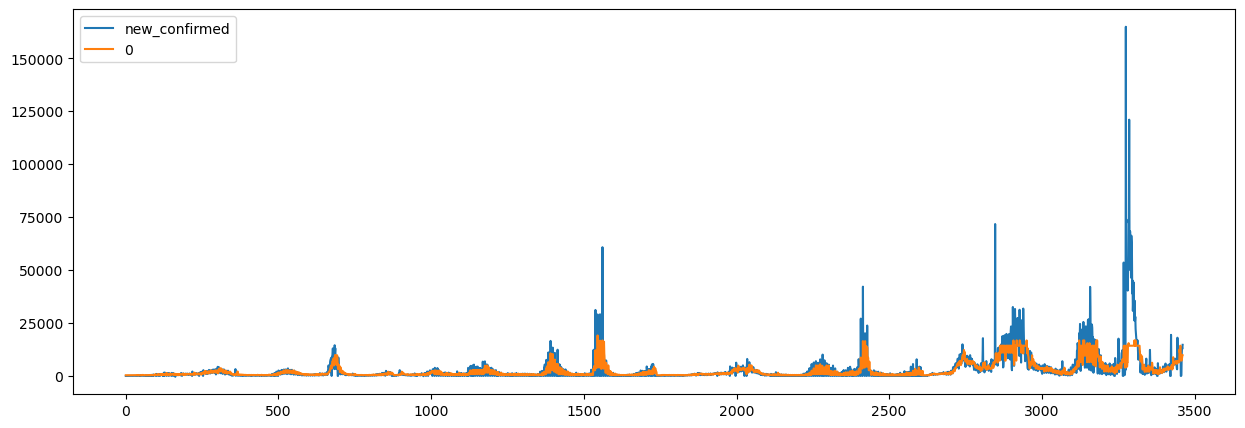

In [89]:
pd.concat([pd.concat([ytrain, ytest]).reset_index().new_confirmed, 
           pd.DataFrame(np.concatenate((train_pred, test_pred)))[0]], axis = 1).plot(figsize = (15,5))

In [111]:
np.array([max(0, x) for x in test_pred])

array([1.51354072e+04, 1.51516133e+04, 3.54370430e+04, 9.75363672e+03,
       1.38576787e+04, 3.30135645e+03, 0.00000000e+00, 5.58119125e+01,
       1.29530557e+04, 9.02719955e+01, 3.63726807e+03, 1.72507217e+02,
       3.27227509e+02, 1.15354111e+04, 1.50856400e+02, 3.90373828e+04,
       3.93314570e+04, 3.87457812e+04, 1.16054707e+04, 1.85438809e+04,
       1.36685947e+04, 1.09020586e+04, 1.28198538e+01, 1.67421914e+04,
       8.76409082e+03, 1.47277109e+04, 1.09158184e+04, 3.54604805e+04,
       1.48264678e+04, 9.59929102e+03, 1.02514326e+04, 1.00396631e+04,
       3.72160352e+03, 6.14444922e+03, 1.03214941e+04, 1.29786299e+04,
       1.67652246e+04, 2.37400137e+04, 2.02872441e+04, 8.99981348e+03,
       3.80998462e+03, 1.84676880e+02, 3.79553076e+03, 1.07043770e+04,
       0.00000000e+00, 3.85667310e+03, 1.18637161e+02, 3.92050562e+03,
       5.85211768e+03, 9.50659027e+01, 2.76155391e+04, 1.24777354e+04,
       2.14483867e+04, 4.04360596e+03, 9.63602441e+03, 1.28568555e+04,
      

In [71]:
pd.concat([ytrain, ytest])

date
2020-03-06        0.0
2020-03-07        0.0
2020-03-08        0.0
2020-03-09        0.0
2020-03-10        0.0
               ...   
2022-07-04      350.0
2022-07-19    10191.0
2022-07-20    13447.0
2022-07-21    12768.0
2022-07-22    14695.0
Name: new_confirmed, Length: 3462, dtype: float64

In [36]:
for data in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
    print(data.region.unique()[0])
    df = data.drop(columns = ['region', 'location_key'])
    df.dropna(inplace = True)
    model = xgb.XGBRegressor()
    y = df.new_confirmed
    X = df.drop(columns = ['new_confirmed'])
    model.fit(X, y)
    stats = pd.DataFrame({'importance': model.feature_importances_}, index=X.columns)
    stats = stats.sort_values('importance', ascending=False)

East North Central
East South Central
Mid-Atlantic
Mountain
New England
Pacific
South Atlantic
West North Central
West South Central


In [37]:
stats

,importance
7_day_avg,0.436162
cumulative_persons_fully_vaccinated,0.122251
7_day_shift,0.117236
workplace_closing,0.058774
cumulative_deceased,0.053433
...,...
location_key_US_SD,0.000000
location_key_US_NJ,0.000000
year,0.000000
cumulative_vaccine_doses_administered_pfizer,0.000000
